In [1]:
import xarray as xr
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
path = 'C:/Users/ABHISHEK/OneDrive/Documents/SSH Data/ostst-single-layer-fd-lat-40-urms-5-kf-13-kr-4-beta.nc'

ds = xr.open_dataset(path)

In [3]:
ds

<xarray.Dataset>
Dimensions:          (j: 1, kl: 11439, x: 256, y: 256, z: 1, t: 1826)
Coordinates:
  * j                (j) float64 1.0
  * kl               (kl) float64 0.0 1.0 2.0 ... 1.144e+04 1.144e+04 1.144e+04
  * x                (x) float64 0.0 7.812e+03 1.562e+04 ... 1.984e+06 1.992e+06
  * y                (y) float64 0.0 7.812e+03 1.562e+04 ... 1.984e+06 1.992e+06
  * z                (z) float64 0.0
  * t                (t) datetime64[ns] 1970-01-01 1970-01-02 ... 1974-12-31
Data variables: (12/19)
    Lx               float64 ...
    Ly               float64 ...
    Lz               float64 ...
    h                (j) float64 ...
    k                (kl) float64 ...
    l                (kl) float64 ...
    ...               ...
    A0bar_realp      (kl, j) float64 ...
    A0bar_imagp      (kl, j) float64 ...
    tau0             float64 ...
    ssh              (t, y, x) float64 ...
    A0_realp         (t, kl, j) float64 ...
    A0_imagp         (t, kl, j) float64 ...
Attributes:
    source:                    Created with the WaveVortexModel version 3
    model_version:             3.0
    date_created:              28-Feb-2025 16:35:34
    history:                   28-Feb-2025 16:35:34: file created.~          ...
    references:                Early, J., Lelong, M., & Sundermeyer, M. (2021...
    WVTransform:               WVTransformSingleMode
    WVNonlinearFluxOperation:  WVNonlinearFluxQGForced
    beta:                      1.7535936850315176e-11
    r:                         1.4137166941154068e-08
    alpha:                     7.068583470577034e-10
    nu_xy:                     59.6006962601987
    shouldUseLinearDynamics:   0

In [5]:
ssh = ds["ssh"]
ts  = ssh.isel(x=0, y=0)        
times = ts["t"].values

In [6]:
n = ts.sizes["t"]
values = ts.values.astype(np.float32)

In [7]:
np.random.seed(42)
obs_idx = np.random.choice(n, size=int(0.1 * n), replace=False)

In [8]:
mask = np.zeros(n, dtype=np.float32)
mask[obs_idx] = 1.0

In [9]:
data = values.copy()
data[mask == 0] = 0.0

In [10]:
X = np.stack([data, mask], axis=1)[None, ...] 
y = values.reshape(1, n, 1)

In [11]:
inp = layers.Input(shape=(n, 2))
x   = layers.Conv1D(64, 5, padding="same", activation="relu")(inp)
x   = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
x   = layers.Conv1D(32, 3, padding="same", activation="relu")(x)
out = layers.Conv1D(1, 3, padding="same", activation=None)(x)
model = models.Model(inputs=inp, outputs=out)

In [12]:
mask_tensor = tf.constant(mask.reshape(1, n, 1), dtype=tf.float32)
def masked_mse(y_true, y_pred):
    missing = 1.0 - mask_tensor
    se = tf.square(y_true - y_pred)
    return tf.reduce_sum(se * missing) / (tf.reduce_sum(missing) + 1e-8)

model.compile(optimizer="adam", loss=masked_mse)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1826, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1826, 64)       │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1826, 64)       │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1826, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1826, 1)        │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,521 (107.50 KB)

 Trainable params: 27,521 (107.50 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(X, y, epochs=200,batch_size=1, verbose=1)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.5588e-04
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.5584e-04
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.5587e-04
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 1.5594e-04
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1.5605e-04
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 1.5619e-04
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.5634e-04
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.5654e-04
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.5675e-04
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.5702e-04
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 1.5727e-04
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.5760e-04
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 1.5784e-04
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.5812e-04
Epoch 15/200
1/1 ━━━━━━━━

In [21]:
y_pred = model.predict(X)[0, :, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


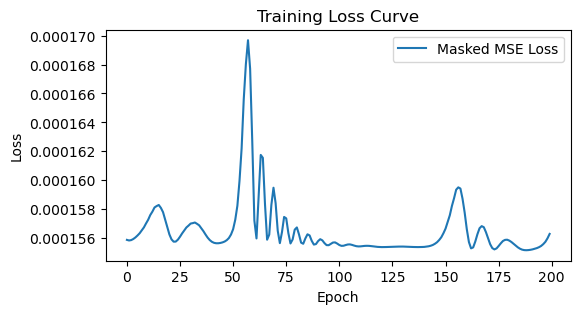

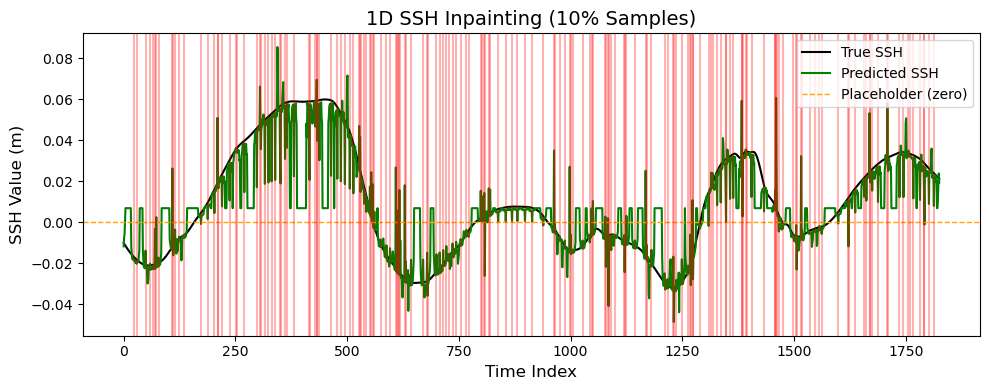

In [22]:

plt.figure(figsize=(6,3))
plt.plot(history.history['loss'], label='Masked MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))


ax.plot(values,    color="black", linewidth=1.5, label="True SSH")


ax.plot(y_pred,    color="green", linewidth=1.5, label="Predicted SSH")

ax.axhline(0, color="orange", linestyle="--", linewidth=1, label="Placeholder (zero)")


for idx in obs_idx:
    ax.axvline(idx, color="red", alpha=0.3)


ax.set_xlabel("Time Index", fontsize=12)
ax.set_ylabel("SSH Value (m)", fontsize=12)
ax.set_title("1D SSH Inpainting (10% Samples)", fontsize=14)
ax.legend(loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()